In [1]:
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

In [2]:
import torch
import torch.nn as nn
import torchvision
from torch import optim
from torchvision import transforms
from torchvision.datasets import ImageFolder

print('torch.cuda.is_available():', torch.cuda.is_available())
print('torch.cuda.device_count():', torch.cuda.device_count())

torch.cuda.is_available(): True
torch.cuda.device_count(): 1


In [3]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import numpy as np

import utils
import models

In [4]:
# Set a seed value
seed = 42 
os.environ['PYTHONHASHSEED']=str(seed)
torch.manual_seed(0)
random.seed(seed)
np.random.seed(seed)

In [5]:
# Allocate gpu memory in advance.
# utils.allocate_gpu_memory()

In [6]:
save_interval = 10
save_dir = './output/centralized'
os.makedirs(save_dir, exist_ok=True)

In [7]:
batch_size = 64
num_workers = 2

data_dir = './data/'
train_dir = os.path.join(data_dir, 'centralized_client_data')
valid_dir = os.path.join(data_dir, 'valid_sub')

transform = transforms.Compose([transforms.Resize((96, 96)), transforms.ToTensor()])

train_data = ImageFolder(train_dir, transform=transform)
valid_data = ImageFolder(valid_dir, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

num_classes = len(train_data.classes)

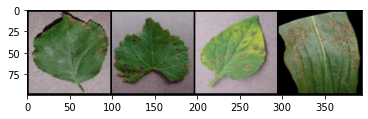

['Apple___Black_rot', 'Grape___Black_rot', 'Tomato___Septoria_leaf_spot', 'Corn___Common_rust']


In [21]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images[:4]))
print([train_data.classes[label] for label in labels[:4]])

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.CNNModel(num_classes=num_classes)
model.to(device)

learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
metric_keys = {'train_loss', 'train_acc', 'valid_loss', 'valid_acc'}
performance_dict, performance_log = utils.get_performance_loggers(metric_keys)

In [11]:
num_epochs = 100
for epoch in range(num_epochs):
    utils.print_separator(text='Epoch: {} / {}'.format(epoch, num_epochs-1))
    # Train. 
    model.train()
    for step, data in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()                                  # Reset gradients.  
        x_batch, y_batch = data[0].to(device), data[1].to(device)                                          
        _, y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        performance_dict['train_loss'].update_state(loss.item())
        performance_dict['train_acc'].update_state(utils.compute_accuracy(y_batch, y_pred))
        
    # Validation.
    model.eval()
    with torch.no_grad():
        for step, data in enumerate(tqdm(valid_loader)):
            x_batch, y_batch = data[0].to(device), data[1].to(device)
            _, y_pred = model(x_batch)
            loss = criterion(y_pred, y_batch)
            performance_dict['valid_loss'].update_state(loss.item())
            performance_dict['valid_acc'].update_state(utils.compute_accuracy(y_batch, y_pred))
    
    for key in metric_keys:
        performance_log[key].append(performance_dict[key].result())
        performance_dict[key].reset_state()
    
    utils.print_result(performance_log)
    
    if  (epoch + 1) % save_interval == 0:
        torch.save(model.state_dict(), os.path.join(save_dir, 'epoch_{}_loss_{:.2f}_acc_{:.2f}.pth'.format(epoch+1, performance_log['valid_loss'][-1], performance_log['valid_acc'][-1])))
        
utils.save_pickle(os.path.join(save_dir, 'performance_log.pickle'), performance_log)


 ==================== Epoch: 0 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 15.53it/s]


train     -              loss :    2.0777          acc:    0.2346
valid     -              loss :    1.5660          acc:    0.4012


 ==================== Epoch: 1 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 15.23it/s]


train     -              loss :    1.2565          acc:    0.5096
valid     -              loss :    1.1303          acc:    0.5692


 ==================== Epoch: 2 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 15.45it/s]


train     -              loss :    0.9622          acc:    0.6301
valid     -              loss :    0.8537          acc:    0.6808


 ==================== Epoch: 3 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 15.65it/s]


train     -              loss :    0.7596          acc:    0.7060
valid     -              loss :    0.8234          acc:    0.6869


 ==================== Epoch: 4 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 15.33it/s]


train     -              loss :    0.6402          acc:    0.7596
valid     -              loss :    0.6129          acc:    0.7838


 ==================== Epoch: 5 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 14.83it/s]


train     -              loss :    0.4959          acc:    0.8138
valid     -              loss :    0.5287          acc:    0.8042


 ==================== Epoch: 6 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 15.20it/s]


train     -              loss :    0.3989          acc:    0.8571
valid     -              loss :    0.7889          acc:    0.7490


 ==================== Epoch: 7 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 15.76it/s]


train     -              loss :    0.3713          acc:    0.8654
valid     -              loss :    0.5397          acc:    0.8075


 ==================== Epoch: 8 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 15.99it/s]


train     -              loss :    0.2807          acc:    0.8971
valid     -              loss :    0.4618          acc:    0.8398


 ==================== Epoch: 9 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 15.43it/s]


train     -              loss :    0.2064          acc:    0.9274
valid     -              loss :    0.5165          acc:    0.8264


 ==================== Epoch: 10 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 15.50it/s]


train     -              loss :    0.1812          acc:    0.9316
valid     -              loss :    0.4735          acc:    0.8623


 ==================== Epoch: 11 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 15.73it/s]


train     -              loss :    0.1291          acc:    0.9528
valid     -              loss :    0.5140          acc:    0.8674


 ==================== Epoch: 12 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 15.33it/s]


train     -              loss :    0.1414          acc:    0.9478
valid     -              loss :    0.5526          acc:    0.8616


 ==================== Epoch: 13 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 15.81it/s]


train     -              loss :    0.1508          acc:    0.9439
valid     -              loss :    0.4253          acc:    0.8852


 ==================== Epoch: 14 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 15.76it/s]


train     -              loss :    0.0956          acc:    0.9693
valid     -              loss :    0.4201          acc:    0.8700


 ==================== Epoch: 15 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 15.28it/s]


train     -              loss :    0.0678          acc:    0.9762
valid     -              loss :    0.6819          acc:    0.8155


 ==================== Epoch: 16 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 15.55it/s]


train     -              loss :    0.0992          acc:    0.9658
valid     -              loss :    0.5616          acc:    0.8797


 ==================== Epoch: 17 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 15.67it/s]


train     -              loss :    0.0465          acc:    0.9838
valid     -              loss :    0.4764          acc:    0.8928


 ==================== Epoch: 18 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 15.31it/s]


train     -              loss :    0.0232          acc:    0.9931
valid     -              loss :    0.5739          acc:    0.8812


 ==================== Epoch: 19 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 15.79it/s]


train     -              loss :    0.0478          acc:    0.9836
valid     -              loss :    0.4729          acc:    0.8903


 ==================== Epoch: 20 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 15.10it/s]


train     -              loss :    0.0250          acc:    0.9904
valid     -              loss :    0.6352          acc:    0.8884


 ==================== Epoch: 21 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 15.62it/s]


train     -              loss :    0.0856          acc:    0.9738
valid     -              loss :    0.6425          acc:    0.8586


 ==================== Epoch: 22 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 15.74it/s]


train     -              loss :    0.1511          acc:    0.9557
valid     -              loss :    0.4369          acc:    0.8754


 ==================== Epoch: 23 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 15.09it/s]


train     -              loss :    0.0634          acc:    0.9772
valid     -              loss :    0.5333          acc:    0.8841


 ==================== Epoch: 24 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 15.48it/s]


train     -              loss :    0.0230          acc:    0.9928
valid     -              loss :    0.4487          acc:    0.8990


 ==================== Epoch: 25 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 15.26it/s]


train     -              loss :    0.0258          acc:    0.9934
valid     -              loss :    0.9152          acc:    0.8329


 ==================== Epoch: 26 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 15.69it/s]


train     -              loss :    0.0855          acc:    0.9714
valid     -              loss :    0.5220          acc:    0.8899


 ==================== Epoch: 27 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 15.67it/s]


train     -              loss :    0.0129          acc:    0.9966
valid     -              loss :    0.4843          acc:    0.9019


 ==================== Epoch: 28 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 15.26it/s]


train     -              loss :    0.0014          acc:    1.0000
valid     -              loss :    0.5229          acc:    0.9048


 ==================== Epoch: 29 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 15.20it/s]


train     -              loss :    0.0003          acc:    1.0000
valid     -              loss :    0.5080          acc:    0.9132


 ==================== Epoch: 30 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 15.79it/s]


train     -              loss :    0.0002          acc:    1.0000
valid     -              loss :    0.5159          acc:    0.9124


 ==================== Epoch: 31 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 15.61it/s]


train     -              loss :    0.0001          acc:    1.0000
valid     -              loss :    0.5215          acc:    0.9121


 ==================== Epoch: 32 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 15.47it/s]


train     -              loss :    0.0001          acc:    1.0000
valid     -              loss :    0.5271          acc:    0.9124


 ==================== Epoch: 33 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 15.56it/s]


train     -              loss :    0.0001          acc:    1.0000
valid     -              loss :    0.5327          acc:    0.9113


 ==================== Epoch: 34 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 15.44it/s]


train     -              loss :    0.0001          acc:    1.0000
valid     -              loss :    0.5375          acc:    0.9113


 ==================== Epoch: 35 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 15.69it/s]


train     -              loss :    0.0000          acc:    1.0000
valid     -              loss :    0.5418          acc:    0.9117


 ==================== Epoch: 36 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 14.93it/s]


train     -              loss :    0.0000          acc:    1.0000
valid     -              loss :    0.5463          acc:    0.9110


 ==================== Epoch: 37 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 15.42it/s]


train     -              loss :    0.0000          acc:    1.0000
valid     -              loss :    0.5504          acc:    0.9113


 ==================== Epoch: 38 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 15.38it/s]


train     -              loss :    0.0000          acc:    1.0000
valid     -              loss :    0.5539          acc:    0.9113


 ==================== Epoch: 39 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 15.89it/s]


train     -              loss :    0.0000          acc:    1.0000
valid     -              loss :    0.5576          acc:    0.9113


 ==================== Epoch: 40 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 16.00it/s]


train     -              loss :    0.0000          acc:    1.0000
valid     -              loss :    0.5611          acc:    0.9117


 ==================== Epoch: 41 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 15.73it/s]


train     -              loss :    0.0000          acc:    1.0000
valid     -              loss :    0.5639          acc:    0.9117


 ==================== Epoch: 42 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 15.70it/s]


train     -              loss :    0.0000          acc:    1.0000
valid     -              loss :    0.5676          acc:    0.9117


 ==================== Epoch: 43 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 15.73it/s]


train     -              loss :    0.0000          acc:    1.0000
valid     -              loss :    0.5703          acc:    0.9121


 ==================== Epoch: 44 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 15.66it/s]


train     -              loss :    0.0000          acc:    1.0000
valid     -              loss :    0.5732          acc:    0.9121


 ==================== Epoch: 45 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 15.87it/s]


train     -              loss :    0.0000          acc:    1.0000
valid     -              loss :    0.5766          acc:    0.9121


 ==================== Epoch: 46 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 15.65it/s]


train     -              loss :    0.0000          acc:    1.0000
valid     -              loss :    0.5792          acc:    0.9124


 ==================== Epoch: 47 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 15.30it/s]


train     -              loss :    0.0000          acc:    1.0000
valid     -              loss :    0.5821          acc:    0.9124


 ==================== Epoch: 48 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 16.06it/s]


train     -              loss :    0.0000          acc:    1.0000
valid     -              loss :    0.5852          acc:    0.9124


 ==================== Epoch: 49 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 16.08it/s]


train     -              loss :    0.0000          acc:    1.0000
valid     -              loss :    0.5878          acc:    0.9124


 ==================== Epoch: 50 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 16.05it/s]


train     -              loss :    0.0000          acc:    1.0000
valid     -              loss :    0.5904          acc:    0.9124


 ==================== Epoch: 51 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 15.74it/s]


train     -              loss :    0.0000          acc:    1.0000
valid     -              loss :    0.5931          acc:    0.9124


 ==================== Epoch: 52 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 16.48it/s]


train     -              loss :    0.0000          acc:    1.0000
valid     -              loss :    0.5956          acc:    0.9124


 ==================== Epoch: 53 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 16.07it/s]


train     -              loss :    0.0000          acc:    1.0000
valid     -              loss :    0.5979          acc:    0.9124


 ==================== Epoch: 54 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 16.63it/s]


train     -              loss :    0.0000          acc:    1.0000
valid     -              loss :    0.6007          acc:    0.9121


 ==================== Epoch: 55 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 16.17it/s]


train     -              loss :    0.0000          acc:    1.0000
valid     -              loss :    0.6033          acc:    0.9117


 ==================== Epoch: 56 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 16.29it/s]


train     -              loss :    0.0000          acc:    1.0000
valid     -              loss :    0.6056          acc:    0.9117


 ==================== Epoch: 57 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 15.71it/s]


train     -              loss :    0.0000          acc:    1.0000
valid     -              loss :    0.6089          acc:    0.9113


 ==================== Epoch: 58 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 16.41it/s]


train     -              loss :    0.0000          acc:    1.0000
valid     -              loss :    0.6174          acc:    0.9113


 ==================== Epoch: 59 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 16.41it/s]


train     -              loss :    0.0000          acc:    1.0000
valid     -              loss :    0.6351          acc:    0.9113


 ==================== Epoch: 60 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 16.62it/s]


train     -              loss :    0.0000          acc:    1.0000
valid     -              loss :    0.6453          acc:    0.9124


 ==================== Epoch: 61 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 16.49it/s]


train     -              loss :    0.0000          acc:    1.0000
valid     -              loss :    0.6549          acc:    0.9102


 ==================== Epoch: 62 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 16.22it/s]


train     -              loss :    0.0000          acc:    1.0000
valid     -              loss :    0.6710          acc:    0.9099


 ==================== Epoch: 63 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 16.60it/s]


train     -              loss :    0.0000          acc:    1.0000
valid     -              loss :    0.6858          acc:    0.9092


 ==================== Epoch: 64 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 16.35it/s]


train     -              loss :    0.0000          acc:    1.0000
valid     -              loss :    0.6868          acc:    0.9110


 ==================== Epoch: 65 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 16.18it/s]


train     -              loss :    0.0000          acc:    1.0000
valid     -              loss :    0.6881          acc:    0.9102


 ==================== Epoch: 66 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 16.37it/s]


train     -              loss :    0.0000          acc:    1.0000
valid     -              loss :    0.6970          acc:    0.9099


 ==================== Epoch: 67 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 16.28it/s]


train     -              loss :    0.0000          acc:    1.0000
valid     -              loss :    0.7077          acc:    0.9099


 ==================== Epoch: 68 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 16.26it/s]


train     -              loss :    0.0000          acc:    1.0000
valid     -              loss :    0.7105          acc:    0.9095


 ==================== Epoch: 69 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 16.55it/s]


train     -              loss :    0.0000          acc:    1.0000
valid     -              loss :    0.7134          acc:    0.9092


 ==================== Epoch: 70 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 16.33it/s]


train     -              loss :    0.0000          acc:    1.0000
valid     -              loss :    0.7117          acc:    0.9088


 ==================== Epoch: 71 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 16.58it/s]


train     -              loss :    0.0000          acc:    1.0000
valid     -              loss :    0.7236          acc:    0.9099


 ==================== Epoch: 72 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 16.09it/s]


train     -              loss :    0.0000          acc:    1.0000
valid     -              loss :    0.7253          acc:    0.9092


 ==================== Epoch: 73 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 16.42it/s]


train     -              loss :    0.0000          acc:    1.0000
valid     -              loss :    0.7260          acc:    0.9092


 ==================== Epoch: 74 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 16.53it/s]


train     -              loss :    0.0000          acc:    1.0000
valid     -              loss :    0.7295          acc:    0.9088


 ==================== Epoch: 75 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 16.43it/s]


train     -              loss :    0.0000          acc:    1.0000
valid     -              loss :    0.7384          acc:    0.9088


 ==================== Epoch: 76 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 16.06it/s]


train     -              loss :    0.0000          acc:    1.0000
valid     -              loss :    0.7406          acc:    0.9088


 ==================== Epoch: 77 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 16.18it/s]


train     -              loss :    0.0000          acc:    1.0000
valid     -              loss :    0.7359          acc:    0.9092


 ==================== Epoch: 78 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 16.20it/s]


train     -              loss :    0.0000          acc:    1.0000
valid     -              loss :    0.7426          acc:    0.9081


 ==================== Epoch: 79 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 16.32it/s]


train     -              loss :    0.0000          acc:    1.0000
valid     -              loss :    0.7497          acc:    0.9088


 ==================== Epoch: 80 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 16.56it/s]


train     -              loss :    0.0000          acc:    1.0000
valid     -              loss :    0.7527          acc:    0.9088


 ==================== Epoch: 81 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 16.45it/s]


train     -              loss :    0.0000          acc:    1.0000
valid     -              loss :    0.7569          acc:    0.9088


 ==================== Epoch: 82 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 16.43it/s]


train     -              loss :    0.0000          acc:    1.0000
valid     -              loss :    0.7626          acc:    0.9084


 ==================== Epoch: 83 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 16.34it/s]


train     -              loss :    0.0000          acc:    1.0000
valid     -              loss :    0.7615          acc:    0.9084


 ==================== Epoch: 84 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 16.24it/s]


train     -              loss :    0.0000          acc:    1.0000
valid     -              loss :    0.7621          acc:    0.9084


 ==================== Epoch: 85 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 16.53it/s]


train     -              loss :    0.0000          acc:    1.0000
valid     -              loss :    0.7690          acc:    0.9081


 ==================== Epoch: 86 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 16.44it/s]


train     -              loss :    0.0000          acc:    1.0000
valid     -              loss :    0.7634          acc:    0.9073


 ==================== Epoch: 87 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 16.66it/s]


train     -              loss :    0.0000          acc:    1.0000
valid     -              loss :    0.7755          acc:    0.9073


 ==================== Epoch: 88 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 16.23it/s]


train     -              loss :    0.0000          acc:    1.0000
valid     -              loss :    0.7731          acc:    0.9088


 ==================== Epoch: 89 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 16.39it/s]


train     -              loss :    0.0000          acc:    1.0000
valid     -              loss :    0.7770          acc:    0.9081


 ==================== Epoch: 90 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 16.40it/s]


train     -              loss :    0.0000          acc:    1.0000
valid     -              loss :    0.7808          acc:    0.9073


 ==================== Epoch: 91 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 16.53it/s]


train     -              loss :    0.0000          acc:    1.0000
valid     -              loss :    0.7819          acc:    0.9095


 ==================== Epoch: 92 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 16.30it/s]


train     -              loss :    0.0000          acc:    1.0000
valid     -              loss :    0.7864          acc:    0.9077


 ==================== Epoch: 93 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 16.43it/s]


train     -              loss :    0.0000          acc:    1.0000
valid     -              loss :    0.7918          acc:    0.9070


 ==================== Epoch: 94 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 16.00it/s]


train     -              loss :    0.0000          acc:    1.0000
valid     -              loss :    0.7915          acc:    0.9077


 ==================== Epoch: 95 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 16.52it/s]


train     -              loss :    0.0000          acc:    1.0000
valid     -              loss :    0.7897          acc:    0.9081


 ==================== Epoch: 96 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 16.38it/s]


train     -              loss :    0.0000          acc:    1.0000
valid     -              loss :    0.7922          acc:    0.9077


 ==================== Epoch: 97 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 16.39it/s]


train     -              loss :    0.0000          acc:    1.0000
valid     -              loss :    0.7980          acc:    0.9077


 ==================== Epoch: 98 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 16.35it/s]


train     -              loss :    0.0000          acc:    1.0000
valid     -              loss :    0.7953          acc:    0.9070


 ==================== Epoch: 99 / 99 ====================



100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 16.42it/s]

train     -              loss :    0.0000          acc:    1.0000
valid     -              loss :    0.8007          acc:    0.9095



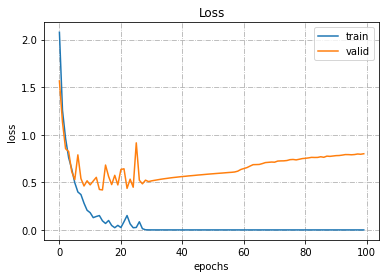

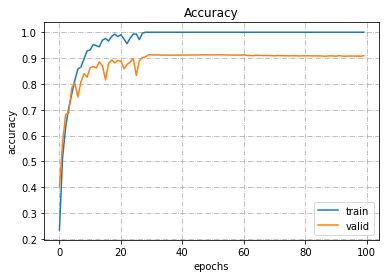

In [12]:
# Plot training history.
loss_plot_config = utils.LOSS_PLOT_CONFIG.copy()
loss_plot_config['save_dir'] = os.path.join(save_dir, 'loss.png')
loss_plot_config['show_img'] = True
loss_plot_config['xlabel'] = 'epochs'
utils.save_history_plot(performance_log, loss_plot_config)

acc_plot_config = utils.ACC_PLOT_CONFIG.copy()
acc_plot_config['save_dir'] = os.path.join(save_dir, 'accuracy.png')
acc_plot_config['show_img'] = True
acc_plot_config['xlabel'] = 'epochs'
utils.save_history_plot(performance_log, acc_plot_config)

In [12]:
# Reload model.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.CNNModel(num_classes=num_classes)
model.to(device)
model.load_state_dict(torch.load(os.path.join(save_dir, 'epoch_100_loss_0.80_acc_0.91.pth')))

performance_log = utils.load_pickle(os.path.join(save_dir, 'performance_log.pickle'))

metric_keys = {'train_loss', 'train_acc', 'valid_loss', 'valid_acc'}
performance_dict, _ = utils.get_performance_loggers(metric_keys)

criterion = nn.CrossEntropyLoss()
# Validation.
model.eval()
with torch.no_grad():
    for step, data in enumerate(tqdm(valid_loader)):
        x_batch, y_batch = data[0].to(device), data[1].to(device)
        _, y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        performance_dict['valid_loss'].update_state(loss.item())
        performance_dict['valid_acc'].update_state(utils.compute_accuracy(y_batch, y_pred))
    
    print('valid_loss:', performance_dict['valid_loss'].result())
    print('valid_acc:', performance_dict['valid_acc'].result())

100%|███████████████████████████████████████████████████████████████████████████████████| 43/43 [00:03<00:00, 14.08it/s]

valid_loss: 0.800685013689712
valid_acc: 0.9095203488372093


In [27]:
print('{:.2f}'.format(performance_log['valid_acc'][-1]))

0.91


In [ ]:
dataiter = iter(valid_loader)

In [ ]:
with torch.no_grad():
    data = dataiter.next()
    x_batch, y_batch = data[0].to(device), data[1].to(device)
    _, y_pred = model(x_batch)
    _, predicted = torch.max(y_pred, 1)
    
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.axis('off')
    plt.imshow(transforms.ToPILImage()(x_batch[i]))
    txt_color = 'green' if (predicted[i] == y_batch[i]) else 'red'
    plt.title(valid_data.classes[predicted[i]], color=txt_color, fontsize=8)
plt.tight_layout()
plt.show()

# imshow(torchvision.utils.make_grid(images[:4]))
# print([train_data.classes[label] for label in labels[:4]])

In [13]:
import copy

In [14]:
model = models.CNNModel(num_classes=num_classes)
model.to(device)
w_server = model.state_dict()
w_server

OrderedDict([('encoder.conv1.weight',
              tensor([[[[ 0.0382,  0.0931,  0.1601],
                        [-0.1078, -0.1014, -0.1700],
                        [ 0.0111, -0.1610,  0.1825]],
              
                       [[-0.0028,  0.0544,  0.1303],
                        [-0.1185,  0.1276, -0.0312],
                        [ 0.0219, -0.0341, -0.0888]],
              
                       [[-0.0413, -0.1459, -0.1544],
                        [-0.0023, -0.1440,  0.1820],
                        [ 0.0014,  0.1306, -0.0699]]],
              
              
                      [[[-0.1377,  0.1206,  0.1820],
                        [-0.0207, -0.0634, -0.0668],
                        [ 0.0649, -0.0789,  0.0718]],
              
                       [[-0.0251, -0.0895, -0.1681],
                        [-0.0973, -0.1293, -0.1252],
                        [-0.1827, -0.1724,  0.1498]],
              
                       [[-0.0616, -0.0183, -0.0892],
                  

In [15]:
# w_next = copy.deepcopy(w_server)
w_next = {}
for k in w_server.keys():
    w_next[k] = torch.zeros_like(w_server[k]).cpu()

In [16]:
w_next

{'encoder.conv1.weight': tensor([[[[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]],
 
          [[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]],
 
          [[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]]],
 
 
         [[[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]],
 
          [[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]],
 
          [[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]]],
 
 
         [[[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]],
 
          [[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]],
 
          [[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]]],
 
 
         ...,
 
 
         [[[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]],
 
          [[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]],
 
          [[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]]],
 
 
         [